<a href="https://colab.research.google.com/github/pedro9olivares/Deep-Learning/blob/main/SurvivalAnalysisCox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Survival Analysis utilizando el modelo de Cox**


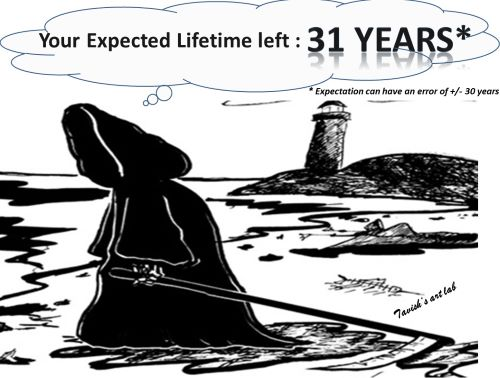

Obtención de datos e información del challenge: https://challengedata.ens.fr/participants/challenges/33/

Los datos están estructurados de la siguiente manera.

En el folder "images", dentro del comprimido de cada paciente (.npz):
*   **mask.npy** = Tensor booleano de 3 dimensiones que representa dónde o no hay un tumor.
*   **scan.npy** = Tensor de 3 dimensiones que representa el scan tomográfico en escala de grises.

En el folder "features":


*   **radiomics.csv** = archivo .csv con 53 variables, exclusivamente numéricas, de datos radiómicos.
*   **clinical_data.csv** = archivo .csv con 6 variables de datos clínicos.







Nota: la extensión .npy representa un formato de archivo binario para guardar un solo arreglo de NumPy en disco. 

Tamaño de los datos: 300 pacientes en el conjunto de entrenamiento (x_train). 125 pacientes en el conjunto de prueba (x_test).

# **Preprocesamiento de los datos de entrenamiento**

Los datos a preprocesar son los siguientes:

En el folder de features dentro de "x_train": 

1.   Datos clínicos (6 variables por paciente)
2.   Features radiómicas (53 variables numéricas por paciente)

Se mezclarán los datos de 1. y 2. en un solo DataFrame.



In [1]:
#Utilizaremos las siguientes librerias para el preprocesamiento:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Datos clínicos**

In [2]:
#Leemos los datos clínicos
clinical_train=pd.read_csv("/content/drive/MyDrive/SurvivalAnalysis/x_train/features/clinical_data.csv", index_col='PatientID')

In [3]:
#Visualización y descripción de los datos clínicos
print(clinical_train.describe())
clinical_train.head()

           Mstage      Nstage      Tstage         age
count  300.000000  300.000000  300.000000  284.000000
mean     0.040000    0.963333    2.103333   68.766856
std      0.314212    1.160378    1.072297    9.587605
min      0.000000    0.000000    1.000000   42.513300
25%      0.000000    0.000000    1.000000   62.979625
50%      0.000000    0.000000    2.000000   69.947300
75%      0.000000    2.000000    3.000000   76.201950
max      3.000000    3.000000    5.000000   87.126600


,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
202,Adenocarcinoma,0,0,l2,2,66.0000
371,large cell,0,2,l1,4,64.5722
246,squamous cell carcinoma,0,3,l1,2,66.0452
240,nos,0,2,l1,3,59.3566
284,squamous cell carcinoma,0,3,l1,4,71.0554


De la descripción de los datos vemos que a la variable "age" le faltan 16 valores.

En el modelo de Cox, evitaremos usar la variable "Mstage" ya que es casi constante a través de todos los pacientes (lo que podría resultar en problemas de convergencia).
 

In [4]:
#Visualización de la variable "Tstage"
clinical_train.Tstage.value_counts(sort=False, dropna=False)

1    105
2    111
3     33
4     50
5      1
Name: Tstage, dtype: int64

Ya que solo un paciente tiene Tstage con categoría 5, este se agrupará con los pacientes que tiene Tstage con categoría 4.

In [5]:
#Movemos a ese paciente
clinical_train['Tstage']=clinical_train.Tstage.apply(lambda x: 4 if x==5 else x)

De igual manera, agrupamos las histologías similares en una nueva columna que las guarda por categorías (0,1,2,3). 

In [7]:
clinical_train['Histology_cat']=clinical_train.Histology.apply(lambda x: 0 if x in ('Adenocarcinoma','adenocarcinoma') 
                                                               else 1 if x=='large cell' 
                                                               else 2 if x in('squamous cell carcinoma', 'Squamous cell carcinoma') 
                                                               else 3)

In [9]:
clinical_train.head()

,Histology,Mstage,Nstage,SourceDataset,Tstage,age,Histology_cat
PatientID,,,,,,,
202,Adenocarcinoma,0,0,l2,2,66.0000,0
371,large cell,0,2,l1,4,64.5722,1
246,squamous cell carcinoma,0,3,l1,2,66.0452,2
240,nos,0,2,l1,3,59.3566,3
284,squamous cell carcinoma,0,3,l1,4,71.0554,2


"Dummificamos" nuestras variables categóricas: Tstage, Nstage and Histology_cat. Es decir, vamos a pasar tener una columna tal:

Tstage 

  0

  1

  2

  ...

  0 

  a tener tantas columnas como valores únicos contenga esta columna original. Las nuevas columnas serán binarias e indicarán si el paciente padece (1) o no (0) esa categoría de variable. Visualmente:

  Tsge1    Tsge2    ...    TsgeN
  
  
  $  \begin{pmatrix}
  0 & 0 & \cdots & 1 \\
  1 & 0 & \cdots & 0 \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  0 & 1 & \cdots & 0
 \end{pmatrix}$        







In [10]:
#(Variables de Mstage y Histology que no serán utilizadas en el análisis son descartadas, i.e., las categorías 0).
#Dummificación
clinical_train=clinical_train.drop(columns=["Mstage", "Histology"])

categories = ['Nstage', 'Tstage', 'Histology_cat']
clinical_train = pd.get_dummies(clinical_train, columns=categories, drop_first=True)
#Visualización
clinical_train.head()

,SourceDataset,age,Nstage_1,Nstage_2,Nstage_3,Tstage_2,Tstage_3,Tstage_4,Histology_cat_1,Histology_cat_2,Histology_cat_3
PatientID,,,,,,,,,,,
202,l2,66.0000,0,0,0,1,0,0,0,0,0
371,l1,64.5722,0,1,0,0,0,1,1,0,0
246,l1,66.0452,0,0,1,1,0,0,0,1,0
240,l1,59.3566,0,1,0,0,1,0,0,0,1
284,l1,71.0554,0,0,1,0,0,1,0,1,0


**Características radiómicas**

In [13]:
#Leemos las características radiómicas
radiomics_train=pd.read_csv("/content/drive/MyDrive/SurvivalAnalysis/x_train/features/radiomics.csv", header=1)
#Visualización (opcional)
radiomics_train.head()

,PatientID,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
0,202,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786,3942944085,5.138062,1.592466,241,-310.858031,288.311105,-266.0,-1006,1247,446.407319,-0.281714,320.385361,0.037008,102646.77950,1056.843506,546253.49980,-5334.563631,555.818455,54.336816,0.821101,3.845383,5.036775,0.005920,9.270194,0.338672,0.262780,-0.175185,0.901525,0.981053,0.917509,0.249416,0.037768,61.035662,6.007130,0.926391,1.457980,555.378594,14592.303730,0.891330,0.003562,954.749136,0.003384,851.987373,0.004444,1651.710761
1,371,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568730,0.240727,43168,3122890068,4.461054,3.371013,262,-134.429809,191.395154,-15.0,-945,1207,268.966000,-1.216062,232.962090,0.080061,54271.33556,1219.689108,331155.23040,-6857.579704,295.032309,16.868781,0.891184,2.984034,2.570017,0.025532,7.551168,0.495719,0.439879,-0.250370,0.932847,0.993282,0.953464,0.340024,0.110575,67.826804,5.255594,0.855154,2.512125,1766.619373,22881.932690,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
2,246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818690,0.200766,52655,1059535256,3.437111,7.585494,115,-54.136093,94.132136,2.0,-785,900,141.852795,-2.153344,131.116356,0.160905,17191.49887,972.465798,54523.08687,-1618.363118,78.183970,7.040623,0.831081,2.333939,1.496020,0.066569,5.686554,0.616607,0.581458,-0.249969,0.884911,0.995095,0.963887,0.379957,0.189723,61.795144,4.159019,0.769265,4.096838,3462.816344,18773.106000,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
3,240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074,658332446,4.352564,4.281865,274,-118.705522,149.072998,-37.0,-850,1124,224.397694,-1.437836,190.429315,0.074476,36263.32402,968.117567,166735.78000,-3968.921514,184.299591,13.656782,0.860096,2.926791,2.492079,0.015048,7.536161,0.457545,0.391681,-0.214233,0.902811,0.993509,0.950374,0.357236,0.050439,60.841486,5.122729,0.880123,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
4,284,0.023691,0.199424,53.795911,1.711620,0.584242,5295.900331,0.327241,16237,807253170,4.055700,8.999616,203,-67.201946,143.210231,14.0,-1023,1226,222.972850,-2.438490,212.604774,0.104419,45200.79010,1594.558416,658805.55400,-10509.915490,248.373464,20.121147,0.849653,2.787526,2.372269,0.029317,6.940307,0.544607,0.501892,-0.238174,0.911356,0.9926

Todos los datos radiómicos están completos, no hace falta modificarlos.

**Mezcla de los datos clínicos con las características radiómicas.**

In [15]:
x_train_svm=pd.merge(radiomics_train, clinical_train, how='inner', left_index=True, right_index=True, sort=True)
x_train_svm.head()

,PatientID,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,SourceDataset,age,Nstage_1,Nstage_2,Nstage_3,Tstage_2,Tstage_3,Tstage_4,Histology_cat_1,Histology_cat_2,Histology_cat_3
2,246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818690,0.200766,52655,1059535256,3.437111,7.585494,115,-54.136093,94.132136,2.0,-785,900,141.852795,-2.153344,131.116356,0.160905,17191.49887,972.465798,54523.08687,-1618.363118,78.183970,7.040623,0.831081,2.333939,1.496020,0.066569,5.686554,0.616607,0.581458,-0.249969,0.884911,0.995095,0.963887,0.379957,0.189723,61.795144,4.159019,0.769265,4.096838,3462.816344,18773.106000,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080,l1,59.4223,0,0,0,0,1,0,0,0,0
3,240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074,658332446,4.352564,4.281865,274,-118.705522,149.072998,-37.0,-850,1124,224.397694,-1.437836,190.429315,0.074476,36263.32402,968.117567,166735.78000,-3968.921514,184.299591,13.656782,0.860096,2.926791,2.492079,0.015048,7.536161,0.457545,0.391681,-0.214233,0.902811,0.993509,0.950374,0.357236,0.050439,60.841486,5.122729,0.880123,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046,l1,77.0986,0,0,1,0,0,0,0,1,0
4,284,0.023691,0.199424,53.795911,1.711620,0.584242,5295.900331,0.327241,16237,807253170,4.055700,8.999616,203,-67.201946,143.210231,14.0,-1023,1226,222.972850,-2.438490,212.604774,0.104419,45200.79010,1594.558416,658805.55400,-10509.915490,248.373464,20.121147,0.849653,2.787526,2.372269,0.029317,6.940307,0.544607,0.501892,-0.238174,0.911356,0.992658,0.958908,0.384513,0.100536,78.421376,4.878253,0.819049,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812,l1,84.5722,0,0,0,0,1,0,0,1,0
5,348,0.030981,0.341038,63.749510,1.431305,0.698663,8493.134012,0.197602,43036,793875568,2.997723,10.782335,499,-28.118041,83.967542,19.0,-840,1339,135.818919,-2.673941,132.876463,0.242181,17656.15448,1156.658925,98556.42374,-2448.908873,90.535215,5.841817,0.877057,2.079147,1.214975,0.118797,4.900170,0.677000,0.651749,-0.291044,0.893251,0.998052,0.979253,0.362410,0.213892,67.393733,3.725974,0.721916,5.942850,3562.648394,11863.541320,0.567217,0.001557,1066.061196,0.001303,725.085582,0.005632,7256.001857,l1,71.8439,0,0,0,1,0,0,0,0,1
7,244,0.020481,0.149037,47.180504,1.886118,0.530189,2391.306856,0.563329,4295,1201381227,5.585623,1.628077,455,-377.200233,3

Procesamiento extra usando [Pipelines](https://https://scikit-learn.org/stable/modules/compose.html#pipeline) de scikit-learn. Esto transforma nuestras columnas radiómicas para mejorar el análisis mediante Cox.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Dummy variables are not going to be transformed and are thus removed temporarily from the dataset.
x_train=x_train_svm.drop(columns=['Nstage_1','Nstage_2','Nstage_3','Tstage_2','Tstage_3','Tstage_4', 'Histology_cat_1', 'Histology_cat_2','Histology_cat_3'])

# Create pipeline for categorical features
categorical_features_1 = ['SourceDataset']

categorical_transformer_1 = Pipeline(
    steps=[('encoder', OneHotEncoder(drop='first'))])
#Variable "SourceDataset" is converted into one-hot vector.

# Create pipeline for numeric features
numeric_features_1 = x_train.select_dtypes(include=['int64','float64']).columns

numeric_transformer_1 = Pipeline(
    steps=[('imputer', SimpleImputer(strategy="median")),('scaler', StandardScaler())
])
#Missing values of numeric variables are replaced by its median (only "age" has missing values)
#Numeric variables are standardized (mean=0, standard deviation=1)

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num_1', numeric_transformer_1, numeric_features_1),
        ('cat', categorical_transformer_1, categorical_features_1)
    ])

x_train_ = preprocessor.fit_transform(x_train)

In [23]:
x_train=pd.DataFrame(x_train_, index=x_train.index, columns=x_train.columns)
#Dummy variables are included in a new dataset in order to be merged with the other variables afterward
test=clinical_train.loc[:,['Nstage_1','Nstage_2','Nstage_3','Tstage_2','Tstage_3','Tstage_4','Histology_cat_1', 'Histology_cat_2','Histology_cat_3']]

#Merge of the transformed variables with the dummy variables
x_train=pd.merge(x_train, test, how='inner', left_index=True, right_index=True, sort=True)
x_train=x_train.rename(columns={'SourceDataset':'age','age':'SourceDataset'})
x_train.head()

,PatientID,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,age,SourceDataset,Nstage_1,Nstage_2,Nstage_3,Tstage_2,Tstage_3,Tstage_4,Histology_cat_1,Histology_cat_2,Histology_cat_3
2,0.200262,0.180257,0.071060,0.266050,-0.329036,0.215021,0.077703,-0.845948,-0.002109,-0.292896,-0.972366,0.017355,-0.711279,0.721710,-0.924099,0.625910,1.226783,-0.954824,-0.940632,-0.598741,-0.986901,0.823418,-0.953734,-0.341517,-0.745877,0.337768,-0.955979,-0.770260,0.375318,-0.903022,-0.903975,0.791841,-1.011253,0.986081,0.984537,-0.441933,-0.082853,0.632278,0.640154,0.816906,1.087216,-0.115182,-0.995401,-0.940670,0.628443,-0.039897,-0.067987,-1.010005,-0.379393,-0.398153,-0.428509,-0.760777,-0.204182,0.228519,-1.030284,0.0,0,0,0,0,1,0,0,0,0
3,0.151257,0.089909,-0.022346,-0.416728,-0.257402,0.127103,-0.490109,-0.135089,-0.487428,-0.365287,0.087810,-0.315634,-0.306387,0.322206,-0.261188,0.426590,0.612392,-0.432024,-0.409450,-0.076573,-0.265577,-0.342675,-0.428442,-0.353682,-0.431307,-0.093825,-0.424664,-0.568871,0.649633,-0.160218,-0.414507,-0.497523,0.068394,-0.081936,-0.119441,0.114951,0.223269,0.489496,0.229729,0.548322,-0.561895,-0.193688,0.067245,0.295430,-0.479671,-0.424488,-0.413977,0.356213,-0.275082,-0.316404,-0.288133,-0.188280,-0.237892,-0.552626,0.870688,0.0,0,0,1,0,0,0,0,1,0
4,0.510630,-0.434993,-0.528378,-0.215005,0.211505,-0.395872,-0.393838,-0.115672,-0.448646,-0.338417,-0.255985,0.159891,-0.487188,0.640869,-0.331928,0.687239,-1.022834,-0.193963,-0.418619,-0.806837,0.004106,0.061311,-0.182278,1.398868,0.948132,-1.294838,-0.103850,-0.372103,0.550904,-0.334708,-0.473382,-0.140448,-0.279416,0.502638,0.521678,-0.258128,0.369384,0.412828,0.488931,0.870761,0.031248,1.253512,-0.202330,-0.385562,-0.075801,-0.385983,-0.428664,-0.337673,0.137362,1.450414,-0.016154,1.538739,0.436584,0.297829,1.674426,0.0,0,0,0,0,1,0,0,1,0
5,1.033353,0.791533,0.751694,0.072776,-0.758545,0.795496,-0.107376,-0.864219,-0.120051,-0.340831,-1.481217,0.339580,0.266574,0.882690,-1.046744,0.712793,0.706914,0.069771,-0.979461,-0.978665,-0.965496,1.919986,-0.940936,0.173787,-0.622437,0.185269,-0.894137,-0.806750,0.809992,-1.222259,-1.042082,2.098899,-1.470278,1.391585,1.393434,-1.081998,0.059778,0.898431,1.106847,0.609490,1.373374,0.345702,-1.472904,-1.468625,1.528590,-0.026081,-0.289449,-1.585540,-0.414040,0.146925,-0.473055,-0.391960,-0.177625,1.217708,0.305579,0.0,0,0,0,1,0,0,0,0,1
7,0.183927,-0.975144,-0.983839,-0.406271,0.815368,-0.958671,-0.654081,

# **Preprocesamiento de los datos de prueba**

Realizamos lo mismo que en la sección anterior, ahora para nuestro dataset de prueba.

**Datos clínicos**

In [24]:
#Carga de datos clínicos
clinical_test=pd.read_csv("/content/drive/MyDrive/SurvivalAnalysis/x_test/features/clinical_data.csv", index_col='PatientID')

In [25]:
#Creamos una nueva columna de histologías agrupadas
clinical_test['Histology_cat']=clinical_test.Histology.apply(lambda x: 0 if x in ('Adenocarcinoma','adenocarcinoma') 
                                                              else 1 if x=='large cell' 
                                                              else 2 if x in('squamous cell carcinoma', 'Squamous cell carcinoma') 
                                                              else 3)
#Nos deshacemos de la columna de Histología original y de Mstage
clinical_test=clinical_test.drop(columns=['Histology','Mstage'])
clinical_test.head()


,Nstage,SourceDataset,Tstage,age,Histology_cat
PatientID,,,,,
13,0,l1,4,44.3970,3
155,3,l1,1,63.3183,0
404,2,l1,2,64.7255,1
407,0,l1,2,65.3635,3
9,0,l2,2,50.0000,0


In [26]:
clinical_test.Nstage.value_counts(sort=False, dropna=False)

0    67
1     5
2    30
3    21
4     2
Name: Nstage, dtype: int64

Como hay solo dos pacientes en categoría 4, los movemos a la categoría 3.

In [27]:
clinical_test['Nstage']=clinical_test.Nstage.apply(lambda x: 3 if x==4 else x)

In [28]:
clinical_test.Tstage.value_counts(sort=False, dropna=False)

1    36
2    48
3    14
4    26
5     1
Name: Tstage, dtype: int64

Hacemos algo similar para Tstage:

In [29]:
clinical_test['Tstage']=clinical_test.Tstage.apply(lambda x: 4 if x==5 else x)

"Dummificamos":

In [30]:
categories = ['Nstage', 'Tstage', 'Histology_cat']
clinical_test = pd.get_dummies(clinical_test, columns=categories, drop_first=True)

**Datos radiómicos**

In [32]:
#Leemos las características radiómicas
radiomics_test=pd.read_csv("/content/drive/MyDrive/SurvivalAnalysis/x_test/features/radiomics.csv", header=1)

Los datos están completos (se puede comprobar).

**Mezclamos los datos clínicos con los radiómicos**

In [33]:
x_test_svm=pd.merge(radiomics_test, clinical_test, how='inner', left_index=True, right_index=True, sort=True)

Usamos Pipelines.

In [34]:
# Dummy variables are not going to be transformed and are thus removed temporarily from the dataset.
x_test=x_test_svm.drop(columns=['Nstage_1','Nstage_2','Nstage_3','Tstage_2','Tstage_3','Tstage_4','Histology_cat_1', 'Histology_cat_2','Histology_cat_3'])

#Same transformation as for train data is applied
x_test_ = preprocessor.transform(x_test)

x_test=pd.DataFrame(x_test_, index=x_test.index, columns=x_test.columns)
#Dummy variables are included in a new dataset in order to be merged with the other variables afterward
test=clinical_test.loc[:,['Nstage_1','Nstage_2','Nstage_3','Tstage_2','Tstage_3','Tstage_4','Histology_cat_1', 'Histology_cat_2','Histology_cat_3']]

#Merge of the transformed variables with the dummy variables
x_test=pd.merge(x_test, test, how='inner', left_index=True, right_index=True, sort=True)
x_test=x_test.rename(columns={'SourceDataset':'age','age':'SourceDataset'})
x_test.head()

,PatientID,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,age,SourceDataset,Nstage_1,Nstage_2,Nstage_3,Tstage_2,Tstage_3,Tstage_4,Histology_cat_1,Histology_cat_2,Histology_cat_3
0,-1.702779,0.438868,0.348666,1.320404,-0.521728,0.463558,1.737640,-1.343895,2.467516,-0.121950,-1.392995,0.678227,0.943940,1.161434,-1.517847,0.712793,2.465018,0.256485,-1.281533,0.460489,-1.520382,1.377673,-1.217569,-0.795662,-0.837674,0.625807,-1.155425,-0.901352,0.699825,-1.573169,-1.189789,1.198432,-1.383432,1.463219,1.479508,-1.323602,0.286683,1.001592,1.280793,1.258696,1.133904,-0.541866,-1.311556,-1.867041,1.452516,2.417520,1.406496,-1.586454,-0.420782,-0.603966,-0.501185,-1.091240,-0.111371,0.366454,0.967628,1.0,0,0,0,0,0,0,0,1,0
1,-0.542986,0.954228,0.947137,-1.226383,-0.859004,0.946092,-0.811938,2.059069,-0.636564,-0.436729,1.077310,-0.539873,-0.851336,-1.907195,0.406337,-1.832370,-0.729817,-0.600066,1.600127,1.003018,0.361463,-0.957255,0.185643,-1.439783,-0.256279,0.494274,0.283583,0.529475,-0.537806,0.938124,1.118747,-0.821694,1.004215,-1.424235,-1.432472,-0.354917,1.161639,-1.182379,-1.573111,-1.622531,-1.078784,-1.481388,1.100583,1.256050,-0.803415,-0.515631,-0.644190,1.288958,0.665519,-1.359760,0.807532,-1.191314,0.170579,-0.946891,0.291749,0.0,0,1,0,1,0,0,0,1,0
6,-1.359742,1.803935,2.065476,-1.197201,-1.311314,1.709319,-0.800066,1.184559,-0.630630,-0.437262,1.055925,-0.555138,-0.782581,-0.935234,0.954599,-0.759109,-0.635295,-0.560390,0.921654,0.680436,0.908065,-0.924854,0.840421,-0.366879,0.176645,-0.235042,0.760722,0.661700,-0.198097,1.022286,1.015760,-0.765763,0.885525,-1.104389,-1.092648,-0.242971,1.027940,-1.216494,-1.332415,-1.124083,-0.772406,-0.341830,1.049856,1.019373,-0.727246,-0.513999,-0.634006,1.031964,-0.022425,-0.471931,0.036322,-0.165073,-0.171392,-0.729932,-0.520613,0.0,0,1,0,0,0,1,0,0,1
9,1.351888,-0.161854,-0.272861,1.715806,-0.044522,-0.121049,1.484718,-1.211105,1.695070,-0.160316,-1.965084,2.317136,0.190179,1.117776,-1.520585,0.769011,-0.001999,0.174798,-1.229867,-2.526782,-1.409079,2.240751,-1.171274,1.024585,-0.695859,0.353217,-1.130106,-0.864298,0.365516,-1.643695,-1.176731,1.931590,-1.771221,1.517126,1.550578,-0.007329,-1.638031,0.964232,1.259811,1.421489,1.828069,1.069127,-1.944305,-1.976199,1.487949,2.462005,0.858700,-1.611990,-0.481436,1.160926,-0.554185,0.449511,-0.226781,1.696305,-2.043591,1.0,0,0,0,1,0,0,0,0,0
10,0.796494,-0.264250,-0.370635,-0.734354,0.048170,-0.223368,-0.653899,0.690084

# **Visualizamos nuestras variables objetivo (tiempo de supervivencia) y de censura**

In [35]:
#Carga de variables objetivo y de censura
y_train = pd.read_csv('/content/drive/MyDrive/SurvivalAnalysis/y_train.csv', index_col=0)
#Acomodamos nuestros datos por ID del paciente
y_train=y_train.sort_index() 
#Visualización
y_train.head()

,SurvivalTime,Event
PatientID,,
2,638,0
3,421,0
4,465,1
5,1295,1
7,1393,0


**Variable de censura**

In [37]:
y_train.Event.value_counts(sort=False, dropna=False)

0    138
1    162
Name: Event, dtype: int64

Observamos que 138 pacientes "escaparon" al estudio, mientras que 162 murieron.

**Variable objetivo (tiempo de supervivencia)**

In [38]:
#Describimos el tiempo de supervivencia en nuestro dataset
y_train['SurvivalTime'].describe()

count     300.000000
mean      867.056667
std       723.538139
min        14.000000
25%       302.500000
50%       644.000000
75%      1298.500000
max      3500.000000
Name: SurvivalTime, dtype: float64

Podemos graficar el tiempo de supervivencia:

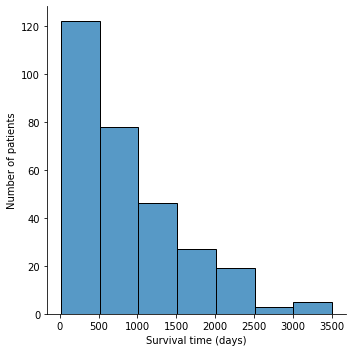

In [39]:
graph = sns.displot(y_train.SurvivalTime, bins=7)
graph.set_axis_labels("Survival time (days)", "Number of patients")

# **Modelo de Cox**

La librería de donde jalamos el modelo de Cox se llama Lifelines. Hay que instalarla.

In [ ]:
!pip install lifelines
from lifelines import CoxPHFitter

**Selección de features relevantes**

Primeramente se hace un análisis univariado (usamos una sola variable en el modelo de Cox) para determinar qué variables impactan más a la supervivencia. Aquellas que no, se descartan.

In [41]:
#Creamos nuestro modelo de Cox
cph = CoxPHFitter()

In [43]:
# Creamos un dataset que contenga todas nuestras variable en x, así como en y.
x_train_model=pd.merge(x_train, y_train, how='inner', left_index=True, right_index=True, sort=True)
x_train.head()

,PatientID,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,age,SourceDataset,Nstage_1,Nstage_2,Nstage_3,Tstage_2,Tstage_3,Tstage_4,Histology_cat_1,Histology_cat_2,Histology_cat_3
2,0.200262,0.180257,0.071060,0.266050,-0.329036,0.215021,0.077703,-0.845948,-0.002109,-0.292896,-0.972366,0.017355,-0.711279,0.721710,-0.924099,0.625910,1.226783,-0.954824,-0.940632,-0.598741,-0.986901,0.823418,-0.953734,-0.341517,-0.745877,0.337768,-0.955979,-0.770260,0.375318,-0.903022,-0.903975,0.791841,-1.011253,0.986081,0.984537,-0.441933,-0.082853,0.632278,0.640154,0.816906,1.087216,-0.115182,-0.995401,-0.940670,0.628443,-0.039897,-0.067987,-1.010005,-0.379393,-0.398153,-0.428509,-0.760777,-0.204182,0.228519,-1.030284,0.0,0,0,0,0,1,0,0,0,0
3,0.151257,0.089909,-0.022346,-0.416728,-0.257402,0.127103,-0.490109,-0.135089,-0.487428,-0.365287,0.087810,-0.315634,-0.306387,0.322206,-0.261188,0.426590,0.612392,-0.432024,-0.409450,-0.076573,-0.265577,-0.342675,-0.428442,-0.353682,-0.431307,-0.093825,-0.424664,-0.568871,0.649633,-0.160218,-0.414507,-0.497523,0.068394,-0.081936,-0.119441,0.114951,0.223269,0.489496,0.229729,0.548322,-0.561895,-0.193688,0.067245,0.295430,-0.479671,-0.424488,-0.413977,0.356213,-0.275082,-0.316404,-0.288133,-0.188280,-0.237892,-0.552626,0.870688,0.0,0,0,1,0,0,0,0,1,0
4,0.510630,-0.434993,-0.528378,-0.215005,0.211505,-0.395872,-0.393838,-0.115672,-0.448646,-0.338417,-0.255985,0.159891,-0.487188,0.640869,-0.331928,0.687239,-1.022834,-0.193963,-0.418619,-0.806837,0.004106,0.061311,-0.182278,1.398868,0.948132,-1.294838,-0.103850,-0.372103,0.550904,-0.334708,-0.473382,-0.140448,-0.279416,0.502638,0.521678,-0.258128,0.369384,0.412828,0.488931,0.870761,0.031248,1.253512,-0.202330,-0.385562,-0.075801,-0.385983,-0.428664,-0.337673,0.137362,1.450414,-0.016154,1.538739,0.436584,0.297829,1.674426,0.0,0,0,0,0,1,0,0,1,0
5,1.033353,0.791533,0.751694,0.072776,-0.758545,0.795496,-0.107376,-0.864219,-0.120051,-0.340831,-1.481217,0.339580,0.266574,0.882690,-1.046744,0.712793,0.706914,0.069771,-0.979461,-0.978665,-0.965496,1.919986,-0.940936,0.173787,-0.622437,0.185269,-0.894137,-0.806750,0.809992,-1.222259,-1.042082,2.098899,-1.470278,1.391585,1.393434,-1.081998,0.059778,0.898431,1.106847,0.609490,1.373374,0.345702,-1.472904,-1.468625,1.528590,-0.026081,-0.289449,-1.585540,-0.414040,0.146925,-0.473055,-0.391960,-0.177625,1.217708,0.305579,0.0,0,0,0,1,0,0,0,0,1
7,0.183927,-0.975144,-0.983839,-0.406271,0.815368,-0.958671,-0.654081,

In [ ]:
#Realizamos el análisis univariado en nuestro modelo de Cox

for variable in x_train.columns:
  #Obtenemos una selección (variable, tiempo de supervivencia, evento)
  x_train_selection=x_train_model.loc[:,[f'{variable}','SurvivalTime','Event']]
  #Entregamos al modelo nuestra selección
  cph.fit(x_train_selection, duration_col='SurvivalTime', event_col='Event')
  #Obtenemos el resumen para esa selección
  print('Variable considerada: ',variable)
  cph.print_summary()

Las variables que se descartarán, a partir del análisis de los resumenes anteriores son:

 *original_shape_Compactness1, original_shape_Compactness2, original_shape_SphericalDisproportion, original_shape_Sphericity, original_firstorder_Energy, original_firstorder_Minimum, original_glcm_ClusterProminence, original_glrlm_LongRunLowGrayLevelEmphasis*

In [46]:
#Descartamos las variables mencionadas
x_train_model_ = x_train_model.drop(columns=["original_shape_Compactness1", "original_shape_Compactness2", 
                                             "original_shape_SphericalDisproportion", "original_shape_Sphericity", 
                                             "original_firstorder_Energy", "original_firstorder_Minimum", 
                                             "original_glcm_ClusterProminence", "original_glrlm_LongRunLowGrayLevelEmphasis"])

**Análisis multivariado**

Habiendo descartado las variables irrelevantes, podemos proceder a ejecutar un análisis multivariado. Es decir, un análisis a través de todo nuestro dataset.

In [47]:
#Análisis multivariado

#Entregamos al modelo todos nuestros datos
#x_train_model.drop(columns=["PatientID"]) #¿Este dato realmente importa?

cph.fit(x_train_model_, duration_col='SurvivalTime', event_col='Event')
cph.print_summary()

/usr/local/lib/python3.7/dist-packages/lifelines/fitters/coxph_fitter.py:1603: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  "Newton-Rhaphson failed to converge sufficiently. {0}".format(CONVERGENCE_DOCS), exceptions.ConvergenceWarning


<lifelines.CoxPHFitter: fitted with 208 total observations, 97 right-censored observations>
             duration col = 'SurvivalTime'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 208
number of events observed = 111
   partial log-likelihood = -520.73
         time fit was run = 2021-08-12 01:21:07 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                            
PatientID                                      0.01       1.01       0.12            -0.22             0.24                 0.80                 1.27
original_shape_Maximum3DDiameter               0.07       1.07       0.33            -0.58             0.71                 0.56                 2.03
original_shape_SurfaceArea                     0.06       1.07       0.83            -1.57             1.70                 0.21                 5.45
original_shape_SurfaceVolumeRatio             -0.01       0.99       0.67            -1.33             1.32                 0.27                 3.73
original_shape_VoxelVolume                    -0.17       0.84       1.22            -2.57             2.22                 0.08                 9.20
original_firstorder_Entropy                    0.48       1.62       5.17            -9.65            10.61                 0.00             40601.96
original_firstorder_Kurtosis                  -0.03       0.97       0.39            -0.79             0.72                 0.45                 2.06
original_firstorder_Maximum                    1.91       6.73       6.37           -10.57            14.39                 0.00             1.77e+06
original_firstorder_Mean                      -0.27       0.77       3.66            -7.45             6.91                 0.00              1006.68
original_firstorder_MeanAbsoluteDeviation     -0.24       0.79       2.90            -5.92             5.45                 0.00               232.38
original_firstorder_Median                    -0.14       0.87       1.61            -3.29             3.01                 0.04                20.35
original_firstorder_Range                     -2.12       0.12       6.99           -15.82            11.59                 0.00             1.08e+05
original_firstorder_RootMeanSquared            0.51       1.67       2.69            -4.75             5.78                 0.01               323.89
original_firstorder_Skewness                  -0.05       0.95       0.44            -0.90             0.80                 0.40                 2.23
original_firstorder_StandardDeviation         -0.43       0.65       2.68            -5.68             4.82                 0.00               123.60
original_firstorder_Uniformity                -0.61       0.54       4.39            -9.22             8.00                 0.00              2973.40
original_firstorder_Variance                  -0.01       0.99       3.61            -7.08             7.06                 0.00              1164.54
original_glcm_Autocorrelation                 -0.00       1.00       4.42            -8.67             8.66                 0.00              5784.26
original_glcm_ClusterShade                    -0.05       0.95       0.46            -0.96             0.86                 0.38                 2.36
original_glcm_ClusterTendency                  0.31       1.36       2.49            -4.57             5.19                 0.01               179.05
original_glcm_Contrast                        -0.23       0.79       5.87           -11.74            11.28                 0.00             78931.63
original_glcm_Correlation                      0.02       1.02       0.55            -1.06             1.10                 0.35                 2.99
original_glcm_DifferenceEntropy     

Obtuvimos la matriz de correlación y las métricas de Concordancia. **Hemos utilizado un modelo de Cox para predecir el tiempo de supervivencia exitosamente.**

Nota del autor: We have the following warning message: "Newton-Rhaphson failed to converge sufficiently". It may be due to multicollinearity which occurs when some features are highly linearly related. Here, the Newton-Raphson's method is used to maximized the Cox partial likelihood.

**Visualización de la matriz de correlación entre variables**

In [48]:
#Obtenemos la matriz de correlación para guardarla en una variable

#(Opcional) Tira las variables no radiómicas
#x_train_model_numeric = x_train_model_.drop(columns=['SourceDataset','SurvivalTime','Event','Nstage_1','Nstage_2','Nstage_3',
#                                                     'Tstage_2','Tstage_3','Tstage_3','Tstage_4',
#                                                     'Histology_cat_1','Histology_cat_2', 'Histology_cat_3'])

corr = x_train_model_.corr()

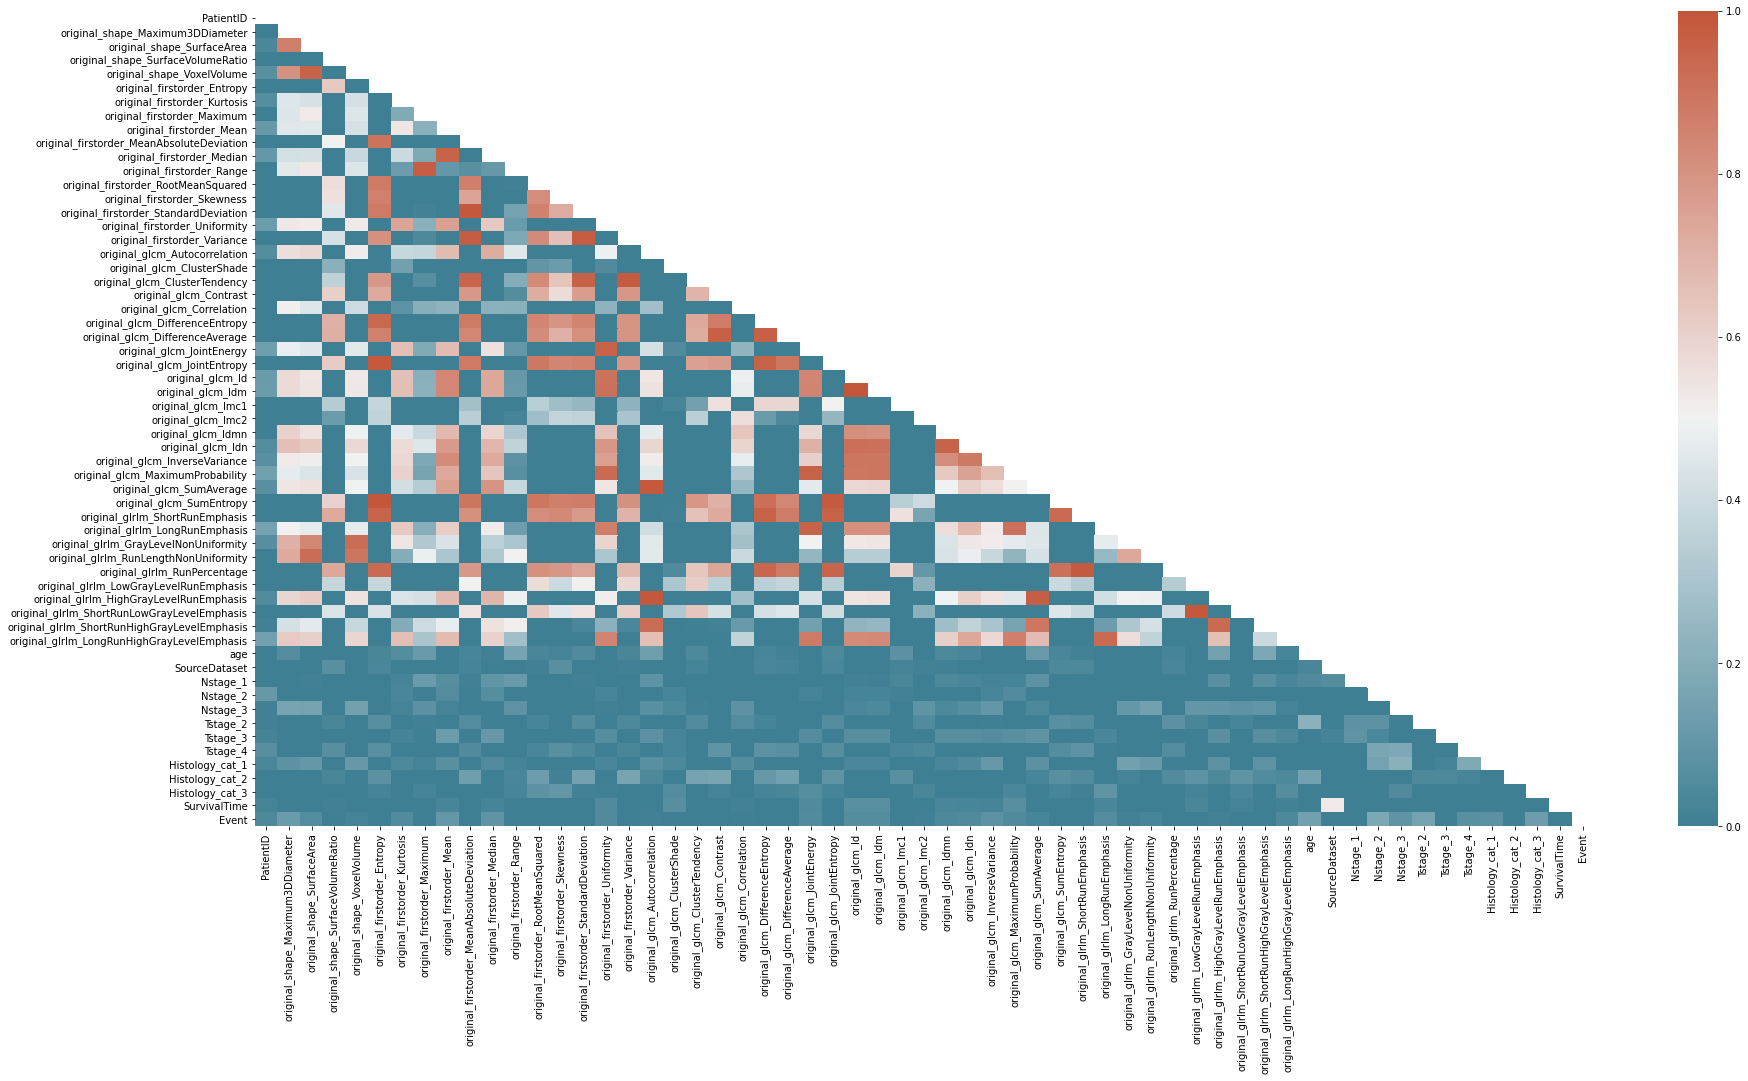

In [49]:
#Ploteamos 

#Figura de matplotlib
f, ax = plt.subplots(figsize=(30, 15))

#Generamos una máscara para la triangular superior. Esto porque las
# correlaciones son exactamente las mismas que en la triangular inferior
mask = np.triu(np.ones_like(corr, dtype=bool))

#Generamos el mapa de color que representa a la matriz de correlación
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, vmin=0, vmax=1)

# **Predicciones**

En los datos de entrenamiento.

In [50]:
# Computo del tiempo de supervivencia esperado.
prediction_train_cph=cph.predict_expectation(x_train_model_)
prediction_train_cph.describe()

count     208.000000
mean     1462.531650
std       146.655773
min       894.476644
25%      1379.252638
50%      1471.781574
75%      1570.207725
max      1755.066223
dtype: float64

En los datos de prueba.

In [51]:
x_test_model = x_test[["original_firstorder_Median","original_glcm_ClusterTendency","original_glrlm_GrayLevelNonUniformity","age",
                       "SourceDataset", "Nstage_1","Nstage_2","Nstage_3",'original_firstorder_Kurtosis', 'original_glcm_Id', 
                       'Histology_cat_1', 'original_glcm_Idmn', 'original_firstorder_Maximum', 'original_firstorder_Range', 
                       'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glcm_Correlation', 'original_glrlm_LongRunEmphasis', 
                       'original_firstorder_RootMeanSquared', 'original_glrlm_RunPercentage', 'original_firstorder_Skewness', 'original_firstorder_Mean', 
                       'original_glcm_JointEntropy', 'original_glcm_SumAverage', 'original_glcm_Autocorrelation', 'original_glrlm_RunLengthNonUniformity', 
                       'Tstage_4', 'original_firstorder_Variance', 'original_glcm_DifferenceEntropy', 'original_glcm_Imc2', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 
                       'original_glcm_Imc1', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_firstorder_Entropy', 'Tstage_3', 
                       'original_glcm_Idm', 'original_glcm_InverseVariance', 'original_glcm_ClusterShade', 'original_firstorder_Uniformity', 'original_firstorder_MeanAbsoluteDeviation', 
                       'Tstage_2', 'original_glcm_Contrast', 'original_glcm_MaximumProbability', 'original_glcm_JointEnergy', 'original_shape_Maximum3DDiameter', 'original_glrlm_ShortRunEmphasis',
                       'original_glcm_DifferenceAverage', 'original_firstorder_StandardDeviation', 'Histology_cat_2', 'original_shape_SurfaceVolumeRatio', 'original_shape_SurfaceArea', 'PatientID', 
                       'original_glcm_Idn', 'original_glcm_SumEntropy', 'original_shape_VoxelVolume', 'Histology_cat_3','original_glrlm_HighGrayLevelRunEmphasis']]

prediction_test_cph=cph.predict_expectation(x_test_model)

Output de tiempos de supervivencia.

In [52]:
output=pd.DataFrame(data=prediction_test_cph)
output=output.rename(columns={0:'Survival_Time'})
print(output.describe())
output.head()

       Survival_Time
count      36.000000
mean     1463.879789
std       153.109732
min      1164.598621
25%      1356.821839
50%      1449.879562
75%      1563.308363
max      1761.628261


,Survival_Time
0,1761.628261
1,1412.389233
6,1450.034480
9,1588.231226
10,1213.581715


In [53]:
#Si se quiere guardar a disco:
#output.to_csv('/content/drive/My Drive/submission_test.csv')

# **Referencias**

Material original: https://github.com/BastienBotrel/Predicting-lung-cancer-survival-time-by-OWKIN

Imagen: https://www.analyticsvidhya.com/blog/2014/04/survival-analysis-model-you/